<a href="https://colab.research.google.com/github/Mutekeri/Covid_19_Confirmed_Cases_in_South_Africa/blob/master/Covid_19_Confirmed_Cases_in_South_Africa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow==2.0.0

     |████████████████████████████████| 86.3MB 47kB/s 
     |████████████████████████████████| 3.8MB 47.4MB/s 
     |████████████████████████████████| 450kB 35.8MB/s 
ERROR: tensorflow-federated 0.12.0 has requirement tensorflow~=2.1.0, but you'll have tensorflow 2.0.0 which is incompatible.
ERROR: tensorflow-federated 0.12.0 has requirement tensorflow-addons~=0.7.0, but you'll have tensorflow-addons 0.8.3 which is incompatible.
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled tensorflow-1.15.0


In [2]:
import tensorflow as tf
print(tf.__version__)

2.0.0


In [0]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [9]:
from google.colab import files
def getLocalFiles():
    _files = files.upload()
    if len(_files) >0:
       for k,v in _files.items():
         open(k,'wb').write(v)
getLocalFiles()

Saving South_Africa_COVID_19.csv to South_Africa_COVID_19 (1).csv


In [10]:
import pandas as pd
data=pd.read_csv(r'South_Africa_COVID_19.csv')
data.head()

,Date,South Africa Cases
0,3/1/2020,0
1,3/2/2020,0
2,3/3/2020,0
3,3/4/2020,0
4,3/5/2020,1


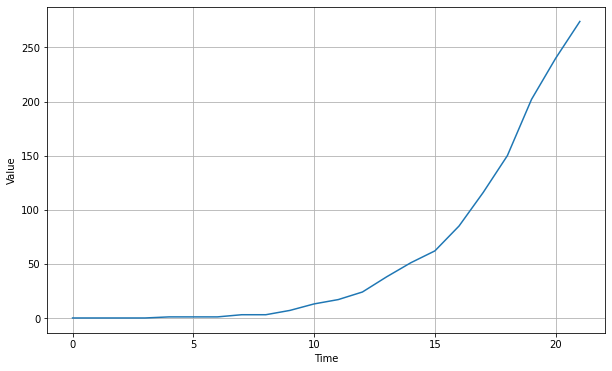

In [11]:
import csv
time_step = []
temps = []

with open(r'South_Africa_COVID_19.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(step)
    step = step + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [0]:
split_time = 17
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 2
batch_size = 4
shuffle_buffer_size = 5

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [0]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(4).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [16]:
tf.keras.backend.clear_session()
tf.random.set_seed(3)
np.random.seed(3)
window_size = 4
batch_size = 16
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(17,)
Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 5.2537 - mae: 5.6525
Epoch 2/100
1/1 [==============================] - 0s 27ms/step - loss: 5.2536 - mae: 5.6524
Epoch 3/100
1/1 [==============================] - 0s 25ms/step - loss: 5.2534 - mae: 5.6522
Epoch 4/100
1/1 [==============================] - 0s 30ms/step - loss: 5.2530 - mae: 5.6519
Epoch 5/100
1/1 [==============================] - 0s 27ms/step - loss: 5.2525 - mae: 5.6514
Epoch 6/100
1/1 [==============================] - 0s 28ms/step - loss: 5.2519 - mae: 5.6509
Epoch 7/100
1/1 [==============================] - 0s 31ms/step - loss: 5.2511 - mae: 5.6502
Epoch 8/100
1/1 [==============================] - 0s 33ms/step - loss: 5.2501 - mae: 5.6494
Epoch 9/100
1/1 [==============================] - 0s 32ms/step - loss: 5.2490 - mae: 5.6484
Epoch 10/100
1/1 [==============================] - 0s 30ms/step 

(1e-08, 0.0001, 0.0, 60.0)

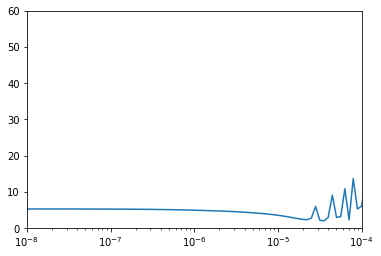

In [17]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [18]:
tf.keras.backend.clear_session()
tf.random.set_seed(3)
np.random.seed(3)
train_set = windowed_dataset(x_train, window_size=8, batch_size=32, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)

Epoch 1/150
1/1 [==============================] - 3s 3s/step - loss: 12.9119 - mae: 13.3608
Epoch 2/150
1/1 [==============================] - 0s 31ms/step - loss: 11.0445 - mae: 11.5307
Epoch 3/150
1/1 [==============================] - 0s 30ms/step - loss: 9.9845 - mae: 10.4756
Epoch 4/150
1/1 [==============================] - 0s 30ms/step - loss: 8.9618 - mae: 9.4585
Epoch 5/150
1/1 [==============================] - 0s 30ms/step - loss: 8.0929 - mae: 8.5679
Epoch 6/150
1/1 [==============================] - 0s 32ms/step - loss: 7.1807 - mae: 7.6727
Epoch 7/150
1/1 [==============================] - 0s 30ms/step - loss: 5.8342 - mae: 6.3223
Epoch 8/150
1/1 [==============================] - 0s 34ms/step - loss: 4.4309 - mae: 4.8949
Epoch 9/150
1/1 [==============================] - 0s 34ms/step - loss: 3.9051 - mae: 4.3039
Epoch 10/150
1/1 [==============================] - 0s 34ms/step - loss: 3.7449 - mae: 4.2108
Epoch 11/150
1/1 [==============================] - 0s 33ms/step -

In [0]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

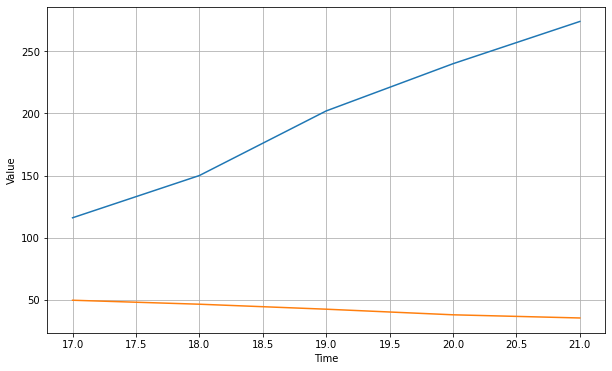

In [20]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [21]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

154.04181

In [22]:
print(rnn_forecast)

[49.642105 46.439224 42.42857  37.918396 35.362686]
